# Embedding Adaptors

In [1]:
# Create document chunks for embedding
from pypdf import PdfReader

# Read the PDF file
reader = PdfReader("microsoft_annual_report_2022.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)

character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

# Further split the chunks to prepare for embedding
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 49 0 (offset 0)
Ignoring wrong pointing object 51 0 (offset 0)
Ignoring wrong pointing object 53 0 (offset 0)
Ignoring wrong pointing object 55 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 72 0 (offset 0)
Ignoring wrong pointing object 162 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)
Ignoring wrong pointing object 252 0 (offset 0)
Ignoring wrong pointing object 257 0 (offset 0)
Ignoring wrong pointing object 294 0 (offset 0)
Ignoring wrong pointing object 299 0 (offset 0)
Ignoring wrong pointing object 319 0 (offset 0)
Ignoring wrong pointing object 331 0 (offset 0)
Ignoring wrong pointing object 336 0 (offset 0)
Ignor

In [2]:
# Setup chroma
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("microsoft_annual_report_2022", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

# Add documents to the vectorbase
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

451

In [3]:
import umap
import numpy as np
from tqdm import tqdm

# Define the projection function
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [4]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|          | 0/451 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/451 [00:00<05:01,  1.49it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

In [5]:
# Setup the OpenAI client for the RAG Operation
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from gen_ai_hub.proxy.native.openai import chat

llm_model = "gpt-35-turbo"

## Creating a dataset

In [ ]:
# Generate some relevant queries
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    kwargs = dict(model_name=llm_model, messages=messages)
    response = chat.completions.create(**kwargs)
    
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [7]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What are the total revenues and net income for the year?
2. What is the company's cash position and liquidity ratios?
3. How much debt does the company have and what are its interest expenses?
4. What are the major sources of revenue for the company?
5. How have the company's revenues and profits changed over the past few years?
6. What is the breakdown of operating expenses for the company?
7. What is the company's capital structure and how has it changed over time?
8. Does the company pay dividends and what is the dividend yield?
9. What are the company's key performance indicators and financial ratios?
10. What is the outlook for the company's industry and how is the company positioned?
11. Does the company have any significant legal or regulatory issues?
12. How does the company compare to its competitors in terms of financial performance?
13. What are the company's strategies for growth and managing risks?
14. What is the company's approach to corporate governance and sustainab

In [8]:
# Query the Chroma collection with the generated queries
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [13]:
# Generate a function to pass each document through an LLM along with a query
# The LLM will rank each document according to its relevance to the query
# The outputs of the function will 1 for relevant and -1 for irrelevant
# This is because the adaptors loss function will be cosine similarity
# In cosine similarity opposite pointing vectors produce a score of -1 while identical vectors produce a score of 1
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    kwargs = dict(model_name=llm_model, messages=messages)
    response = chat.completions.create(**kwargs)
    
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [14]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [15]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [16]:
# Create a dataset to train the adaptor
# The dataset is composed of triplets of query embeddings, document embeddings, and the evaluation model's attributed relevancy label
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


In [17]:
len(adapter_labels)

150

In [18]:
import torch

# Convert the dataset to tensors
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [19]:

# Pack the tensors into a dataset to train the adaptor model
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [20]:
# The adaptor model is a simple linear layer
# The model will take the query and document embeddings as input
# Then it will multiply the query embeddings by the adaptor matrix
# Finally, it will calculate the cosine similarity between the updated query embeddings and the document embeddings
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [ ]:
# Define the loss function
# The loss function is the mean squared error between the model's output 
# and the true label (attributed by the evaluation model earlier)
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [22]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [ ]:
min_loss = float('inf')
best_matrix = None

# Train the adaptor model for 100 epochs
# The model will attempt to find the adaptor matrix that minimizes the loss function
# The model will update the adaptor matrix using the gradient of the loss function
# This is a similar process to training a single linear layer in a neural network
for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:03<00:00, 32.39it/s]


In [24]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5572601556777954


In [25]:
# Observe which dimensions of the query embedding are most affetr by the adaptor matrix multiplication
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

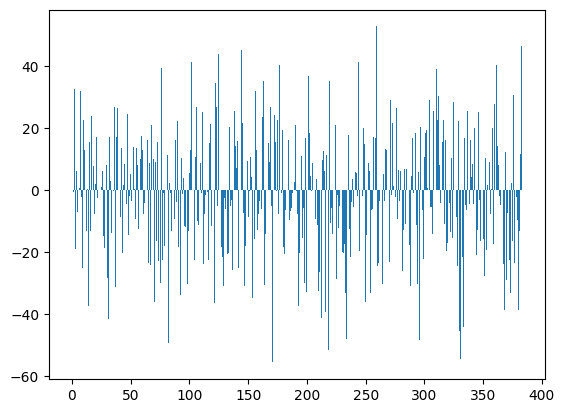

In [26]:
# Plot the scaled dimension vector
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [ ]:
# Project the query embeddings and the adapted query embeddings for comparison
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)